## Average Payoff and Gradient

### tf.GradientTape is a TensorFlow context manager used to record operations for automatic differentiation. This allows us to compute the gradient of a given function with respect to its input variables.

#### 1. Simulate the Price Path: Use the Geometric Brownian Motion (GBM) model to simulate the price path of the underlying asset.
#### 2. Calculate the Payoff: Compute the payoff of a European call option at maturity.
#### 3. Compute the Gradient: Use TensorFlow to calculate the gradient of the payoff with respect to the initial price of the underlying asset.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#### Compute the Gradient (delta): This tells us how much the expected payoff changes when we make a small change in the initial stock price.

We define the initial stock price S0_tf as a TensorFlow variable.
Using TensorFlow's GradientTape, we simulate the price path of the underlying asset in a similar manner as before, but within the TensorFlow framework.
We then calculate the expected payoff of the call option by taking the mean of the payoffs and discounting it to the present value.
Finally, we compute the gradient of the expected payoff with respect to the initial stock price S0_tf using tape.gradient.

In [2]:
# Parameters
S0 = 100  
K = 100  
T = 1.0  
r = 0.05  
sigma = 0.2  
n_steps = 100  # Number of time steps
n_simulations = 100000  # Number of simulations

# Simulate GBM paths
dt = T / n_steps
np.random.seed(123)
S = np.zeros((n_simulations, n_steps + 1))
# update whole S
S[:, 0] = S0
for t in range(1, n_steps + 1):
    Z = np.random.standard_normal(n_simulations)
    S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

# Calculate the payoff of the call option
payoff = np.maximum(S[:, -1] - K, 0)

# TensorFlow computation
S0_tf = tf.Variable(S0, dtype=tf.float64)

with tf.GradientTape() as tape:
    S_tf = S0_tf * tf.exp(tf.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * tf.random.normal((n_simulations, n_steps), dtype=tf.float64), axis=1))
    S_tf = tf.concat([tf.ones((n_simulations, 1), dtype=tf.float64) * S0_tf, S_tf], axis=1)
    payoff_tf = tf.maximum(S_tf[:, -1] - K, 0)
    expected_payoff = tf.reduce_mean(payoff_tf) * np.exp(-r * T)
    
# tf.reduce_mean(payoff_tf) calculates the mean of the values 
# in the payoff_tf tensor along a specified axis (or axes) if provided.

# Calculate the gradient
gradient = tape.gradient(expected_payoff, S0_tf) # gradient of expected_payoff rpt S0_tf

print("Expected payoff:", expected_payoff.numpy())
print("Gradient:", gradient.numpy())


Expected payoff: 10.524130655600617
Gradient: 0.6390236981145818


option's price will theoretically move 0.639 for every 1 change in the price of the underlying stock or index.

#### Above, we could change dtype=tf.float32 (faster speed)

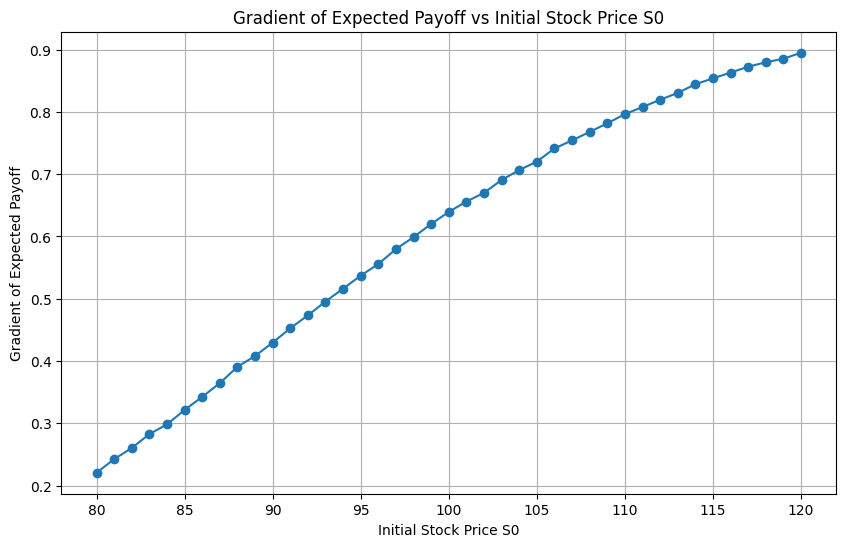

[0.2205635796531274,
 0.24228264534780303,
 0.2602316088846244,
 0.2826218548562247,
 0.298200073246956,
 0.32132048197639745,
 0.34239493821831013,
 0.364441807740971,
 0.3906328260452669,
 0.4080047400225448,
 0.42943036254445804,
 0.4526109216406542,
 0.4732392397721724,
 0.4955389197090066,
 0.5162266566482939,
 0.5370850103286631,
 0.5556984222990815,
 0.5796819964968054,
 0.5990039039461865,
 0.6200819982523189,
 0.6394491210938947,
 0.656084087604491,
 0.670015298776035,
 0.6907428629739775,
 0.7066835086362095,
 0.7202104989730718,
 0.741306738843587,
 0.7543633901606489,
 0.7678868767534486,
 0.7817433243532079,
 0.7964718416283598,
 0.8078903232122872,
 0.819580938152576,
 0.8305055060816435,
 0.8444933176103914,
 0.8539812182058584,
 0.8631488954283656,
 0.8726620245342592,
 0.8797084510115831,
 0.8854822650298658,
 0.8950814482036392]

In [3]:
# Parameters
K = 100  
T = 1.0  
r = 0.05  
sigma = 0.2  
n_steps = 100  # Number of time steps
n_simulations = 100000  # Number of simulations
dt = T / n_steps  # Time step size

# write in tensorflow format
r_tf = tf.constant(r, dtype=tf.float64)
sigma_tf = tf.constant(sigma, dtype=tf.float64)
dt_tf = tf.constant(dt, dtype=tf.float64)

# Simulation function
def simulate_and_compute_gradient(S0):
    S0_tf = tf.Variable(S0, dtype=tf.float64)
    with tf.GradientTape() as tape:
        Z = tf.random.normal((n_simulations, n_steps), dtype=tf.float64)
        increments = (r_tf - 0.5 * sigma_tf**2) * dt_tf + sigma_tf * np.sqrt(dt_tf) * Z
        log_paths = tf.cumsum(increments, axis=1)
        S_paths = S0_tf * tf.exp(log_paths)
        S_paths = tf.concat([tf.ones((n_simulations, 1), dtype=tf.float64) * S0_tf, S_paths], axis=1)
        payoff = tf.maximum(S_paths[:, -1] - K, 0.0)
        expected_payoff = tf.reduce_mean(payoff) * tf.exp(-r_tf * T)
    gradient = tape.gradient(expected_payoff, S0_tf)
    return expected_payoff.numpy(), gradient.numpy()

# Calculate gradients over a range of S0 values
S0_values = np.linspace(80, 120, 41)
gradients = []
for S0 in S0_values:
    _, grad = simulate_and_compute_gradient(S0)
    gradients.append(grad)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S0_values, gradients, '-o')
plt.title('Gradient of Expected Payoff vs Initial Stock Price S0')
plt.xlabel('Initial Stock Price S0')
plt.ylabel('Gradient of Expected Payoff')
plt.grid(True)
plt.show()

gradients